# Data Analytics 

## Prediction of Thoroughbred horses' value basing on parent matching

Authors: 

Michał Motyl
Kamil Pieprzycki

### Problem describtion

The aim of the project is to predict the potential value of racehorses obtained through parental crossbreeding. The main objective is to analyze the impact of sporting results and, based on that analysis, create models that will allow the estimation of investment value.

The reasearch can be a valuable information for investors and horsebreeders to predict investment profitability in horses trening and breeding. The potential usecase is to evaulate value of the young horse with the data of parent and on this basis check if is it worth to invest.

Data used for the purpose of this assignment comes from following website:

- https://sporthorse-data.com/pedigree - Data Base containg information about horses' statisctics and characteristics

Together with individual knowledge of the topic(ownership of Thoroughbred horse bought on auction) we were able to make informed assumtions to help with overall process 

### DAG 


The value of a horse is influenced by numerous variables, including some undefined ones such as individual training or rearing location. For the purposes of the project, assumptions were made to minimize their significance. The dataset consists of randomly selected horses that competed in races within a specified timeframe of 1968 to 1975 in the United States. With these assumptions, it can be inferred that rearing techniques and training methods were very similar. Additionally, the factor of jockeys in races with very similar physical conditions was omitted.

As additional factors can be assumed horse's height, allergies or illnesses, however data was incomplete and therefore their effects cound not be investigated in the project. According to our reaserch height has no corelation with the sport results and ill horses do not participate in races.


As input values 10 variables were chosen as influential initial raw after data analysis:

- Stalion's racing starts count
- Stalion's Number of 1st places
- Stalion's Number of 2nd places
- Stalion's Number of 3rd places
- Stalion's value
- Mare's racing starts count
- Mare's Number of 1st places
- Mare's Number of 2nd places
- Mare' sNumber of 3rd places
- Mare's value

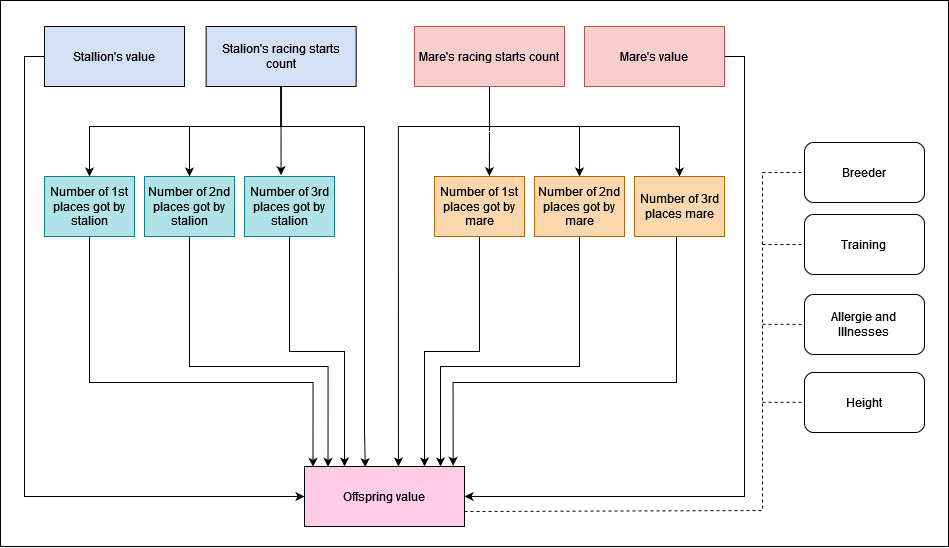

In [2]:
from PIL import Image
image = Image.open("OFFSPRING_DAG.jpg")
display(image)

TODO DODAC DAG DESCRIBTION

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import scipy
from cmdstanpy import CmdStanModel
from cmdstanpy import install_cmdstan

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
path_to_prepared_data = 'data/data_prepared/prepared_horses.csv'
df = pd.read_csv(path_to_prepared_data)
df_no_nan = df.dropna().reset_index()
df_no_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              68 non-null     int64  
 1   Unnamed: 0         68 non-null     int64  
 2   kid_id             68 non-null     int64  
 3   mum_id             68 non-null     object 
 4   dad_id             68 non-null     object 
 5   value_numeric      68 non-null     float64
 6   sex                68 non-null     object 
 7   dad_value_numeric  68 non-null     float64
 8   dad_first_place    68 non-null     float64
 9   dad_second_place   68 non-null     float64
 10  dad_third_place    68 non-null     float64
 11  dad_num_of_starts  68 non-null     float64
 12  mum_value_numeric  68 non-null     float64
 13  mum_first_place    68 non-null     float64
 14  mum_second_place   68 non-null     float64
 15  mum_third_place    68 non-null     float64
 16  mum_num_of_starts  68 non-nu

In [5]:
sex_dict = {'S': 1, 'M': 1, 'F': 0}
df_no_nan.sex.map(sex_dict).info()


<class 'pandas.core.series.Series'>
RangeIndex: 68 entries, 0 to 67
Series name: sex
Non-Null Count  Dtype
--------------  -----
68 non-null     int64
dtypes: int64(1)
memory usage: 672.0 bytes


In [6]:
from sklearn.preprocessing import StandardScaler

# rescaling values
df_copy = df_no_nan.drop(['kid_id', 'mum_id', 'dad_id', 'Unnamed: 0', 'sex', 'value_numeric'], axis=1)
columns_names = df_copy.columns
scaler = StandardScaler()
scaler.fit(df_copy)
df_copy = pd.DataFrame(scaler.transform(df_copy))
df_copy.columns = columns_names
df_copy['sex'] = df_no_nan.sex.map(sex_dict)
df_copy['value_numeric'] = df_no_nan['value_numeric']/(10**6)

# x - mu
# ------
#  sig

df_copy.head()

,index,dad_value_numeric,dad_first_place,dad_second_place,dad_third_place,dad_num_of_starts,mum_value_numeric,mum_first_place,mum_second_place,mum_third_place,mum_num_of_starts,sex,value_numeric
0,-1.592089,-0.785413,-0.674433,-0.942679,-0.772553,-0.917248,-0.167345,0.249083,0.409922,0.682997,0.085781,1,0.132570
1,-1.549483,-0.785413,-0.674433,-0.942679,-0.772553,-0.917248,-0.167345,0.249083,0.409922,0.682997,0.085781,0,0.030739
2,-1.506877,3.436815,3.755368,1.106249,0.678651,2.008112,-0.167345,0.249083,0.409922,0.682997,0.085781,1,0.631605
3,-1.464271,0.339120,-0.022992,-0.649975,-0.192071,-0.499339,-0.167345,0.249083,0.409922,0.682997,0.085781,1,0.008963
4,-1.421665,0.339120,-0.022992,-0.649975,-0.192071,-0.499339,-0.167345,0.249083,0.409922,0.682997,0.085781,1,0.004799


# Data exploration

### Histogram of date we want to predict

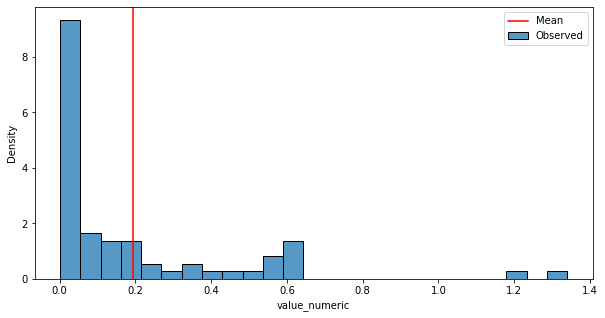

In [7]:
fig, axs = plt.subplots(1,1, figsize=(10,5))
graph = sns.histplot(data=df_copy, x='value_numeric', bins=25, ax=axs, label='Observed',stat='density')
graph.axvline(df_copy.value_numeric.mean(), color='red', label='Mean')
graph.legend()
plt.show()

# Model 1


1. The lognormal distribution was chosen as the first model for predicting offspring values, as it was deemed the most suitable for our case.
2. The chosen distribution is suitable because the majority of horses being sold are priced lower, as it is an auction market and we do not assume any upper limits. Moreover, it should be noted that cases of expensive horses are very rare.
3. In this model we will be using all of our previously chosen predictors (as stated in the introduction section).

The model is created in accordance to the formulae:


$$output_{value} \sim Lognormal(\mu, \sigma) $$
$$\sigma = (1 - predictor_{\omega}) \cdot \theta + \omega_1 \cdot predictor_{\omega}$$
$$\mu = (1-predictor_{\omega}) \cdot \ln(\frac{\mu_x^2}{\sqrt{\mu_x^2 + \sigma_x^2}}) + \omega_2 \cdot predictor_{\omega}$$
$$ \mu_x = predictor_i \cdot \beta + \alpha_0$$

Where: 

- $ \mu, \sigma $ - calculated variables for lognormal distribution 
- $ \mu_x, \sigma_x $ - mean and variance of the distribution ($\mu_x$ calculated the same as inprevious model $\mu$)
- $ \alpha_0 $ - intercept
- $ \beta $ - vector of chosen coefficients
- $predictor_i$ - data obtained for i'th example
- $\omega_i$ - appropriate coefficient for $predictor_{\omega}$


## Prior Predictive Check

The first step involved creating a simple generated quantities model without any predictors.
The mean value of offspring value is sampled from a exponetial distibution. Predictors are generated in accordance to previously validated distributions. The goal was to 
choose priors that would generate a sensible spread of offspring values.

In [8]:
model_ppc1=CmdStanModel(stan_file='models/v2_model1_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [9]:
data = { 'N': len(df_copy),
        'dad_val': df_copy.dad_value_numeric,
        'dad_ns': df_copy.dad_num_of_starts,
        'dad_fp': df_copy.dad_first_place,
        'dad_sp': df_copy.dad_second_place,
        'dad_tp': df_copy.dad_third_place,
        'mum_val': df_copy.mum_value_numeric,
        'mum_fp': df_copy.mum_first_place,
        'mum_sp': df_copy.mum_second_place,
        'mum_tp': df_copy.mum_third_place,
        'mum_ns': df_copy.mum_num_of_starts
         }

sim_ppc1 = model_ppc1.sample(data=data, 
                        iter_sampling=1000,
                        iter_warmup=0, 
                        chains=1, 
                        fixed_param=True,
                        # show_console=True,
                        seed=20230613)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [10]:
sim_ppc1_df = sim_ppc1.draws_pd()
sim_ppc1_df.head()

,lp__,accept_stat__,dad_ns_coef,dad_fp_coef,dad_sp_coef,dad_tp_coef,dad_val_coef,mum_ns_coef,mum_fp_coef,mum_sp_coef,...,output[59],output[60],output[61],output[62],output[63],output[64],output[65],output[66],output[67],output[68]
0,0.0,0.0,-0.304634,-0.354504,0.136220,0.347574,0.006887,0.257142,-0.048270,-0.160676,...,1.435080e-03,171.701000,8.227330e+00,1.370960e-01,3.111310e+01,4.190540e+03,1.491540e-04,5.687630e+03,9.444580e-03,0.039380
1,0.0,0.0,-0.152502,-0.217005,-0.087212,-0.465658,-0.105448,-0.396894,0.045998,0.488346,...,3.241010e+07,41.022900,3.439360e+10,2.884150e-04,3.011830e+11,3.146920e-01,5.794720e-11,3.414030e+12,6.172660e-01,2.195820
2,0.0,0.0,0.099383,-0.513015,0.643032,0.274804,0.065112,-0.203932,-0.025541,-0.178153,...,1.672260e+01,0.097914,4.661480e+02,1.577890e-03,5.182010e+01,5.995610e-01,2.126160e+03,3.505290e-01,3.297070e-02,1.917680
3,0.0,0.0,-0.074955,-0.205452,-0.378234,-0.804714,0.057341,-0.178150,0.400882,0.097183,...,2.680610e-02,115.410000,1.348730e-01,2.093310e+01,3.359510e+02,4.626540e-08,5.761180e+04,4.488650e-06,5.393580e-08,0.000027
4,0.0,0.0,-0.452171,-0.083522,0.536916,0.111460,-0.458669,0.002754,-0.212660,0.063571,...,3.633110e-01,0.001134,3.894550e+01,2.390630e+08,4.240630e-01,9.048830e+05,2.707980e+02,1.463340e-04,1.933760e+02,0.001913


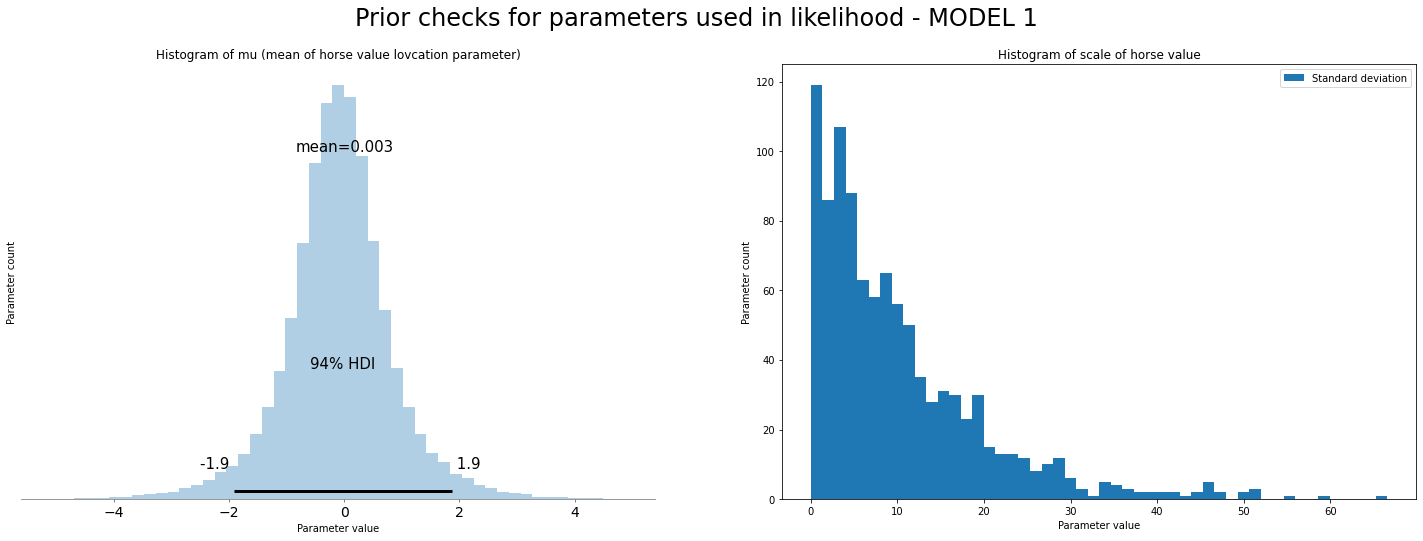

In [11]:
fig1, ax1= plt.subplots(1,2, figsize=(25,8))
fig1.suptitle("Prior checks for parameters used in likelihood - MODEL 1", fontsize=24)

# get distance coeff (flatten because its MxN matrix (data samples x algo samples))
model1_ppc_mu = sim_ppc1.stan_variable('mu').flatten()

# plot distance coeff
az.plot_posterior(model1_ppc_mu, kind='hist', ax=ax1[0], bins=np.linspace(-5,5,50), group='prior', log=False)
ax1[0].set_frame_on(True)
ax1[0].set_xlabel("Parameter value")
ax1[0].set_ylabel("Parameter count")
ax1[0].set_title("Histogram of mu (mean of horse value lovcation parameter)")

# get meal_prep_coeff coeff
model1_ppc_sigma = sim_ppc1.stan_variable('sigma')

# plot meal_prep_coeff coeff
ax1[1].hist(model1_ppc_sigma,label="Standard deviation", bins=50)
ax1[1].legend()
ax1[1].set_xlabel("Parameter value")
ax1[1].set_ylabel("Parameter count")
ax1[1].set_title("Histogram of scale of horse value")
plt.show()


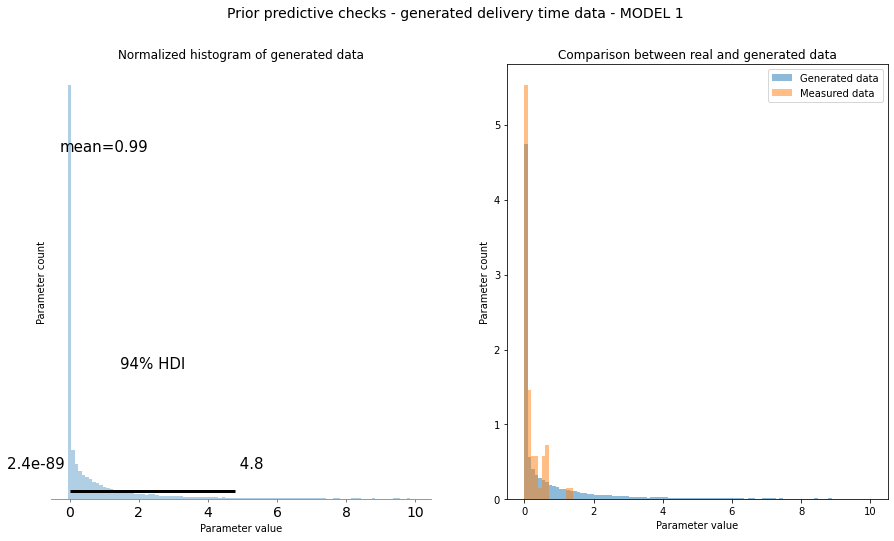

In [12]:
fig2, ax2= plt.subplots(1,2, figsize=(15,8))
fig2.suptitle("Prior predictive checks - generated delivery time data - MODEL 1", fontsize=14)

# get measurements
model1_ppc_measurements = sim_ppc1.stan_variable('output').flatten()  # flatten makes it row/column vector (one of these)

# set bins
bins = np.linspace(0, 10, 100)

az.plot_posterior(model1_ppc_measurements[model1_ppc_measurements<10], kind='hist', ax=ax2[0], bins=bins, group='prior', backend="matplotlib", log=False)
ax2[0].set_xlabel("Parameter value")
ax2[0].set_ylabel("Parameter count")
ax2[0].set_title("Normalized histogram of generated data")

# # plot measurements
ax2[1].hist(model1_ppc_measurements[model1_ppc_measurements<10], density=True, bins=bins,  alpha=0.5, label="Generated data")

# compare with real data, density set to True because each data point sampled 999 times
ax2[1].hist(df_copy['value_numeric'], density=True, bins=bins, alpha=0.5, label="Measured data", log=False)
ax2[1].legend()
ax2[1].set_xlabel("Parameter value")
ax2[1].set_ylabel("Parameter count")
ax2[1].set_title("Comparison between real and generated data")
plt.show()


As can be observed the chosen prior performs well with generating similar distribution for offspring value where the cheaper horses are much more often then the expensive ones. However it does not reflect it perfectly and it should be expanded upon in the future.


## Posterior check 

In [13]:
model1_posterior = model_ppc1=CmdStanModel(stan_file='models/v2_model1_post.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [14]:
data = { 'N': len(df_copy),
        'output': df_copy.value_numeric,
        'dad_val': df_copy.dad_value_numeric,
        'dad_ns': df_copy.dad_num_of_starts,
        'dad_fp': df_copy.dad_first_place,
        'dad_sp': df_copy.dad_second_place,
        'dad_tp': df_copy.dad_third_place,
        'mum_val': df_copy.mum_value_numeric,
        'mum_fp': df_copy.mum_first_place,
        'mum_sp': df_copy.mum_second_place,
        'mum_tp': df_copy.mum_third_place,
        'mum_ns': df_copy.mum_num_of_starts
         }

sim_post1 = model1_posterior.sample(data=data, 
                        iter_sampling=1000,
                        iter_warmup=0, 
                        chains=1, 
                        fixed_param=True,
                        # show_console=True,
                        seed=20230613)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [15]:
sim_post1_df = sim_post1.draws_pd()
sim_post1_df.head()

,lp__,accept_stat__,dad_ns_coef,dad_fp_coef,dad_sp_coef,dad_tp_coef,dad_val_coef,mum_ns_coef,mum_fp_coef,mum_sp_coef,...,log_likelyhood[59],log_likelyhood[60],log_likelyhood[61],log_likelyhood[62],log_likelyhood[63],log_likelyhood[64],log_likelyhood[65],log_likelyhood[66],log_likelyhood[67],log_likelyhood[68]
0,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,0.371536,-17.6693,-40.0638,-0.571657,-0.048561,-16.2068,-7.79077,-1.27065,-3.78095,-23.0498
1,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,0.371536,-17.6693,-40.0638,-0.571657,-0.048561,-16.2068,-7.79077,-1.27065,-3.78095,-23.0498
2,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,0.371536,-17.6693,-40.0638,-0.571657,-0.048561,-16.2068,-7.79077,-1.27065,-3.78095,-23.0498
3,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,0.371536,-17.6693,-40.0638,-0.571657,-0.048561,-16.2068,-7.79077,-1.27065,-3.78095,-23.0498
4,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,0.371536,-17.6693,-40.0638,-0.571657,-0.048561,-16.2068,-7.79077,-1.27065,-3.78095,-23.0498


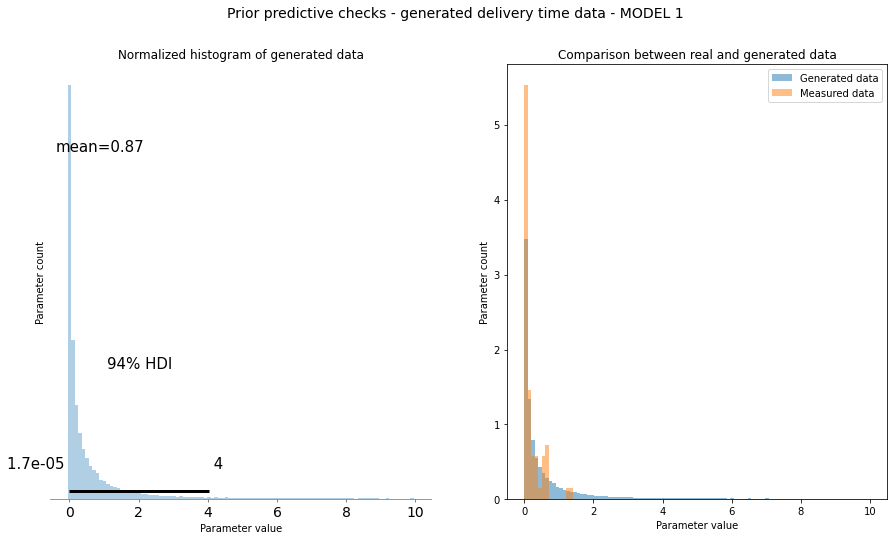

In [16]:
fig2, ax2= plt.subplots(1,2, figsize=(15,8))
fig2.suptitle("Prior predictive checks - generated delivery time data - MODEL 1", fontsize=14)

# get measurements
model1_ppc_measurements = sim_post1.stan_variable('output_pred').flatten()  # flatten makes it row/column vector (one of these)

# set bins
bins = np.linspace(0, 10, 100)

az.plot_posterior(model1_ppc_measurements[model1_ppc_measurements<10], kind='hist', ax=ax2[0], bins=bins, group='prior', backend="matplotlib", log=False)
ax2[0].set_xlabel("Parameter value")
ax2[0].set_ylabel("Parameter count")
ax2[0].set_title("Normalized histogram of generated data")

# # plot measurements
ax2[1].hist(model1_ppc_measurements[model1_ppc_measurements<10], density=True, bins=bins,  alpha=0.5, label="Generated data")

# compare with real data, density set to True because each data point sampled 999 times
ax2[1].hist(df_copy['value_numeric'], density=True, bins=bins, alpha=0.5, label="Measured data", log=False)
ax2[1].legend()
ax2[1].set_xlabel("Parameter value")
ax2[1].set_ylabel("Parameter count")
ax2[1].set_title("Comparison between real and generated data")
plt.show()

Model with added posterior predictors performs well within range of the observed data. 
Used data contains peaks that is a result of action bidding. There is a long tail to the right side where values exceed the maximum observed horse values. There is no visible peaks for horses of higher values where interest of investors is reaching their barrier price.


# Model 1.1

In this model, the lognormal distribution was also used, with the difference that different coefficients were applied for respective genders.

## Prior Predictive Check

## Posterior Predictive Check

# Model 2

In the second model, the half-normal distribution was used. 

The probability density function (PDF) of the half-normal distribution is given by:
$$
output_{value} \sim HalfNormal(\mu, \sigma)
$$

Where:

- **Probability Density Function (PDF)** of the half-normal distribution for \(x \geq 0\):

$$
f(x | \mu, \sigma) = \frac{2}{\sigma \sqrt{2\pi}} \exp \left( -\frac{x^2}{2\sigma^2} \right)
$$

For \(x < 0\), the probability density is zero.

- **Cumulative Distribution Function (CDF)** of the half-normal distribution:

$$
F(x | \mu, \sigma) = \int_{0}^{x} f(t | \mu, \sigma) dt
$$

- **Calculating Parameters** for the half-normal distribution:

$$
\sigma = \theta
$$

$$
\mu = \ln \left( \frac{\mu_x^2}{\sqrt{\mu_x^2 + \sigma_x^2}} \right)
$$

$$
\mu_x = predictor_i \cdot \beta + \alpha_0
$$

Where:

- $ \mu, \sigma $: Calculated variables for the half-normal distribution.
- $ \mu_x, \sigma_x $ : Mean and variance of the distribution  $\mu_x $ is calculated the same as in the previous model $ \mu $.
- $\alpha_0 $: Intercept.
- $\beta$: Vector of chosen coefficients.
- $predictor_i$: Data obtained for the i'th example.


## Prior Predictive Check

In [17]:
model_ppc2=CmdStanModel(stan_file='models/v2_model2_ppc_m.stan')

INFO:cmdstanpy:compiling stan file /home/final_project/racehorse_bayes/models/v2_model2_ppc_m.stan to exe file /home/final_project/racehorse_bayes/models/v2_model2_ppc_m


INFO:cmdstanpy:compiled model executable: /home/final_project/racehorse_bayes/models/v2_model2_ppc_m


In [18]:
data = { 'N': len(df_copy),
        'dad_val': df_copy.dad_value_numeric,
        'dad_ns': df_copy.dad_num_of_starts,
        'dad_fp': df_copy.dad_first_place,
        'dad_sp': df_copy.dad_second_place,
        'dad_tp': df_copy.dad_third_place,
        'mum_val': df_copy.mum_value_numeric,
        'mum_fp': df_copy.mum_first_place,
        'mum_sp': df_copy.mum_second_place,
        'mum_tp': df_copy.mum_third_place,
        'mum_ns': df_copy.mum_num_of_starts
         }

sim_ppc2 = model_ppc2.sample(data=data, 
                        iter_sampling=1000,
                        iter_warmup=0, 
                        chains=1, 
                        fixed_param=True,
                        # show_console=True,
                        seed=20230613)

INFO:cmdstanpy:CmdStan start processing
chain 1 |▊         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [19]:
sim_ppc2_df = sim_ppc2.draws_pd()
sim_ppc2_df.head()

,lp__,accept_stat__,dad_ns_coef,dad_fp_coef,dad_sp_coef,dad_tp_coef,dad_val_coef,mum_ns_coef,mum_fp_coef,mum_sp_coef,...,output[59],output[60],output[61],output[62],output[63],output[64],output[65],output[66],output[67],output[68]
0,0.0,0.0,-0.304634,-0.354504,0.136220,0.347574,0.006887,0.257142,-0.048270,-0.160676,...,0.043413,0.214914,0.175458,0.135955,0.026620,0.038281,0.002510,0.039007,0.007356,0.301947
1,0.0,0.0,-0.152502,-0.217005,-0.087212,-0.465658,-0.105448,-0.396894,0.045998,0.488346,...,0.000142,0.087849,0.283120,0.187514,0.231740,0.216089,0.203373,0.233117,0.216472,0.664810
2,0.0,0.0,0.099383,-0.513015,0.643032,0.274804,0.065112,-0.203932,-0.025541,-0.178153,...,0.085802,0.250022,0.040262,0.107955,0.002319,0.013262,0.006796,0.014579,0.020380,0.125704
3,0.0,0.0,-0.074955,-0.205452,-0.378234,-0.804714,0.057341,-0.178150,0.400882,0.097183,...,0.327966,0.340386,0.162150,0.054522,0.272379,0.244859,0.278614,0.250404,0.245045,0.847081
4,0.0,0.0,-0.452171,-0.083522,0.536916,0.111460,-0.458669,0.002754,-0.212660,0.063571,...,0.084103,0.181655,0.568545,0.456649,0.100549,0.115117,0.107006,0.092580,0.106669,0.215918


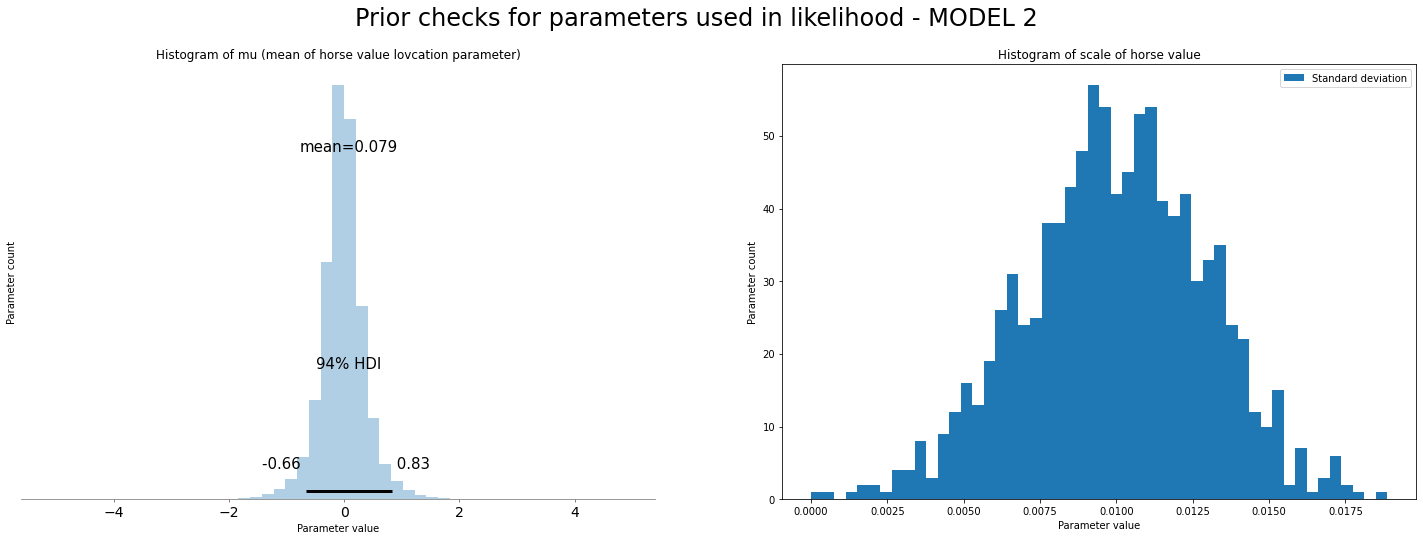

In [20]:
fig1, ax1= plt.subplots(1,2, figsize=(25,8))
fig1.suptitle("Prior checks for parameters used in likelihood - MODEL 2", fontsize=24)

# get distance coeff (flatten because its MxN matrix (data samples x algo samples))
model2_ppc_mu = sim_ppc2.stan_variable('mu').flatten()

# plot distance coeff
az.plot_posterior(model2_ppc_mu, kind='hist', ax=ax1[0], bins=np.linspace(-5,5,50), group='prior', log=False)
ax1[0].set_frame_on(True)
ax1[0].set_xlabel("Parameter value")
ax1[0].set_ylabel("Parameter count")
ax1[0].set_title("Histogram of mu (mean of horse value lovcation parameter)")

# get meal_prep_coeff coeff
model2_ppc_sigma = sim_ppc2.stan_variable('sigma')

# plot meal_prep_coeff coeff
ax1[1].hist(model2_ppc_sigma,label="Standard deviation", bins=50)
ax1[1].legend()
ax1[1].set_xlabel("Parameter value")
ax1[1].set_ylabel("Parameter count")
ax1[1].set_title("Histogram of scale of horse value")
plt.show()


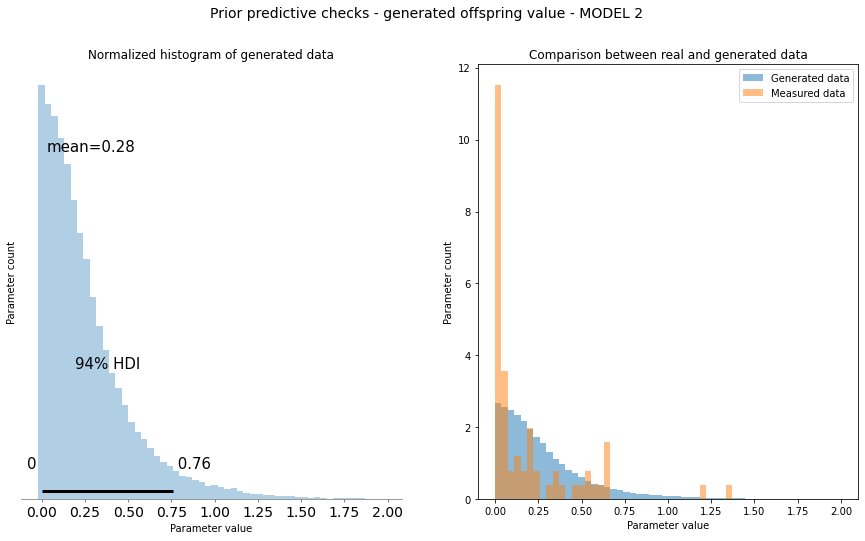

In [21]:
fig2, ax2= plt.subplots(1,2, figsize=(15,8))
fig2.suptitle("Prior predictive checks - generated offspring value - MODEL 2", fontsize=14)

# get measurements
model2_ppc_measurements = sim_ppc2.stan_variable('output').flatten()  # flatten makes it row/column vector (one of these)

# set bins
bins = np.linspace(0,2, 55)
# bins1 = np.linspace(0, 25, 100)

az.plot_posterior(model2_ppc_measurements[model2_ppc_measurements<100], kind='hist', ax=ax2[0], bins=bins, group='prior', backend="matplotlib", log=False)
ax2[0].set_xlabel("Parameter value")
ax2[0].set_ylabel("Parameter count")
ax2[0].set_title("Normalized histogram of generated data")

# # plot measurements
ax2[1].hist(model2_ppc_measurements[model2_ppc_measurements<100], density=True, bins=bins,  alpha=0.5, label="Generated data")

# compare with real data, density set to True because each data point sampled 999 times
ax2[1].hist(df_copy['value_numeric'], density=True, bins=bins, alpha=0.5, label="Measured data", log=False)
ax2[1].legend()
ax2[1].set_xlabel("Parameter value")
ax2[1].set_ylabel("Parameter count")
ax2[1].set_title("Comparison between real and generated data")
plt.show()

## Posterior

In [22]:
model2_posterior = CmdStanModel(stan_file='models/v2_model2_post_m.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [23]:
data = { 'N': len(df_copy),
        'output': df_copy.value_numeric,
        'dad_val': df_copy.dad_value_numeric,
        'dad_ns': df_copy.dad_num_of_starts,
        'dad_fp': df_copy.dad_first_place,
        'dad_sp': df_copy.dad_second_place,
        'dad_tp': df_copy.dad_third_place,
        'mum_val': df_copy.mum_value_numeric,
        'mum_fp': df_copy.mum_first_place,
        'mum_sp': df_copy.mum_second_place,
        'mum_tp': df_copy.mum_third_place,
        'mum_ns': df_copy.mum_num_of_starts
         }

sim_post2 = model2_posterior.sample(data=data, 
                        iter_sampling=1000,
                        iter_warmup=0, 
                        chains=1, 
                        fixed_param=True,
                        # show_console=True,
                        seed=20230613)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [24]:
sim_post2_df = sim_post2.draws_pd()
sim_post2_df.head()

,lp__,accept_stat__,dad_ns_coef,dad_fp_coef,dad_sp_coef,dad_tp_coef,dad_val_coef,mum_ns_coef,mum_fp_coef,mum_sp_coef,...,log_likelyhood[59],log_likelyhood[60],log_likelyhood[61],log_likelyhood[62],log_likelyhood[63],log_likelyhood[64],log_likelyhood[65],log_likelyhood[66],log_likelyhood[67],log_likelyhood[68]
0,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,-7.50502,-7.03315,-12.3995,-0.849125,-1.24091,-0.521885,-0.531401,-0.599855,-0.550545,-0.488972
1,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,-7.50502,-7.03315,-12.3995,-0.849125,-1.24091,-0.521885,-0.531401,-0.599855,-0.550545,-0.488972
2,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,-7.50502,-7.03315,-12.3995,-0.849125,-1.24091,-0.521885,-0.531401,-0.599855,-0.550545,-0.488972
3,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,-7.50502,-7.03315,-12.3995,-0.849125,-1.24091,-0.521885,-0.531401,-0.599855,-0.550545,-0.488972
4,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,-7.50502,-7.03315,-12.3995,-0.849125,-1.24091,-0.521885,-0.531401,-0.599855,-0.550545,-0.488972


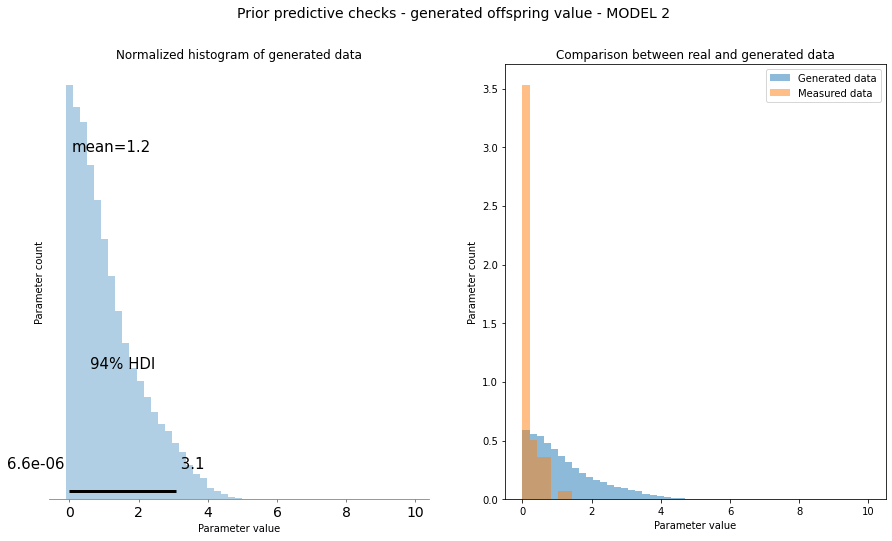

In [25]:
fig2, ax2= plt.subplots(1,2, figsize=(15,8))
fig2.suptitle("Prior predictive checks - generated offspring value - MODEL 2", fontsize=14)

# get measurements
model2_post_measurements = sim_post2.stan_variable('output_pred').flatten()  # flatten makes it row/column vector (one of these)

# set bins
bins = np.linspace(0, 10, 50)
# bins2 = np.linspace(0, 10, 100)
az.plot_posterior(model2_post_measurements[model2_post_measurements<10], kind='hist', ax=ax2[0], bins=bins, group='prior', backend="matplotlib", log=False)
ax2[0].set_xlabel("Parameter value")
ax2[0].set_ylabel("Parameter count")
ax2[0].set_title("Normalized histogram of generated data")

# # plot measurements
ax2[1].hist(model2_post_measurements[model2_post_measurements<10], density=True, bins=bins,  alpha=0.5, label="Generated data")

# compare with real data, density set to True because each data point sampled 999 times
ax2[1].hist(df_copy['value_numeric'], density=True, bins=bins, alpha=0.5, label="Measured data", log=False)
ax2[1].legend()
ax2[1].set_xlabel("Parameter value")
ax2[1].set_ylabel("Parameter count")
ax2[1].set_title("Comparison between real and generated data")
plt.show()

# Model 2.5*

Prior Predictive Check

In [38]:
model_ppc25=CmdStanModel(stan_file='models/v2_model2_ppc.stan')

INFO:cmdstanpy:compiling stan file /home/final_project/racehorse_bayes/models/v2_model2_ppc.stan to exe file /home/final_project/racehorse_bayes/models/v2_model2_ppc


INFO:cmdstanpy:compiled model executable: /home/final_project/racehorse_bayes/models/v2_model2_ppc


In [39]:
data = { 'N': len(df_copy),
        'dad_val': df_copy.dad_value_numeric,
        'dad_ns': df_copy.dad_num_of_starts,
        'dad_fp': df_copy.dad_first_place,
        'dad_sp': df_copy.dad_second_place,
        'dad_tp': df_copy.dad_third_place,
        'mum_val': df_copy.mum_value_numeric,
        'mum_fp': df_copy.mum_first_place,
        'mum_sp': df_copy.mum_second_place,
        'mum_tp': df_copy.mum_third_place,
        'mum_ns': df_copy.mum_num_of_starts
         }

sim_ppc25 = model_ppc25.sample(data=data, 
                        iter_sampling=1000,
                        iter_warmup=0, 
                        chains=1, 
                        fixed_param=True,
                        # show_console=True,
                        seed=20230613)

sim_ppc25_df = sim_ppc25.draws_pd()
sim_ppc25_df.head()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,dad_ns_coef,dad_fp_coef,dad_sp_coef,dad_tp_coef,dad_val_coef,mum_ns_coef,mum_fp_coef,mum_sp_coef,...,output[59],output[60],output[61],output[62],output[63],output[64],output[65],output[66],output[67],output[68]
0,0.0,0.0,-0.304634,-0.354504,0.136220,0.347574,0.006887,0.257142,-0.048270,-0.160676,...,0.005930,0.050605,0.094360,0.076651,0.019151,0.018143,0.021667,0.018080,0.020815,0.089180
1,0.0,0.0,-0.152502,-0.217005,-0.087212,-0.465658,-0.105448,-0.396894,0.045998,0.488346,...,0.028985,0.005749,0.136234,0.044742,0.056721,0.054532,0.052754,0.056913,0.054586,0.222693
2,0.0,0.0,0.099383,-0.513015,0.643032,0.274804,0.065112,-0.203932,-0.025541,-0.178153,...,0.001493,0.066669,0.017812,0.015835,0.032426,0.033662,0.031398,0.033811,0.034465,0.076762
3,0.0,0.0,-0.074955,-0.205452,-0.378234,-0.804714,0.057341,-0.178150,0.400882,0.097183,...,0.096169,0.097809,0.033253,0.050022,0.071858,0.069732,0.072339,0.070160,0.069746,0.293802
4,0.0,0.0,-0.452171,-0.083522,0.536916,0.111460,-0.458669,0.002754,-0.212660,0.063571,...,0.057676,0.043623,0.240842,0.140275,0.011647,0.013405,0.012426,0.010686,0.012385,0.056361


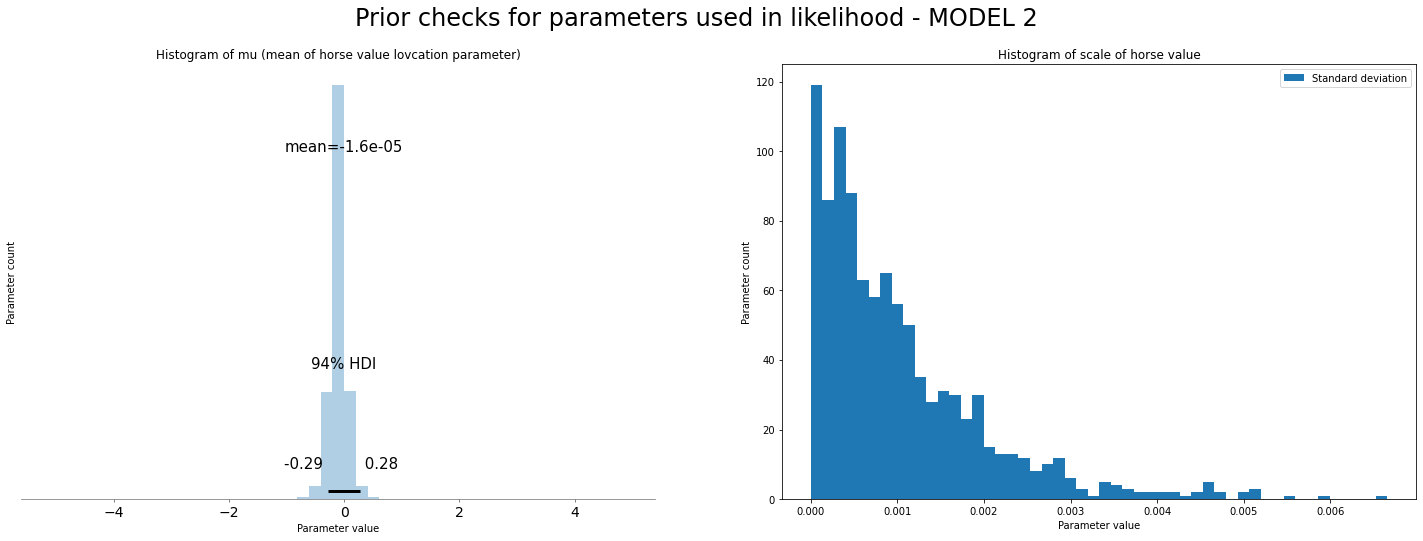

In [40]:
fig1, ax1= plt.subplots(1,2, figsize=(25,8))
fig1.suptitle("Prior checks for parameters used in likelihood - MODEL 2", fontsize=24)

# get distance coeff (flatten because its MxN matrix (data samples x algo samples))
model25_ppc_mu = sim_ppc25.stan_variable('mu').flatten()

# plot distance coeff
az.plot_posterior(model25_ppc_mu, kind='hist', ax=ax1[0], bins=np.linspace(-5,5,50), group='prior', log=False)
ax1[0].set_frame_on(True)
ax1[0].set_xlabel("Parameter value")
ax1[0].set_ylabel("Parameter count")
ax1[0].set_title("Histogram of mu (mean of horse value lovcation parameter)")

# get meal_prep_coeff coeff
model25_ppc_sigma = sim_ppc25.stan_variable('sigma')

# plot meal_prep_coeff coeff
ax1[1].hist(model25_ppc_sigma,label="Standard deviation", bins=50)
ax1[1].legend()
ax1[1].set_xlabel("Parameter value")
ax1[1].set_ylabel("Parameter count")
ax1[1].set_title("Histogram of scale of horse value")
plt.show()

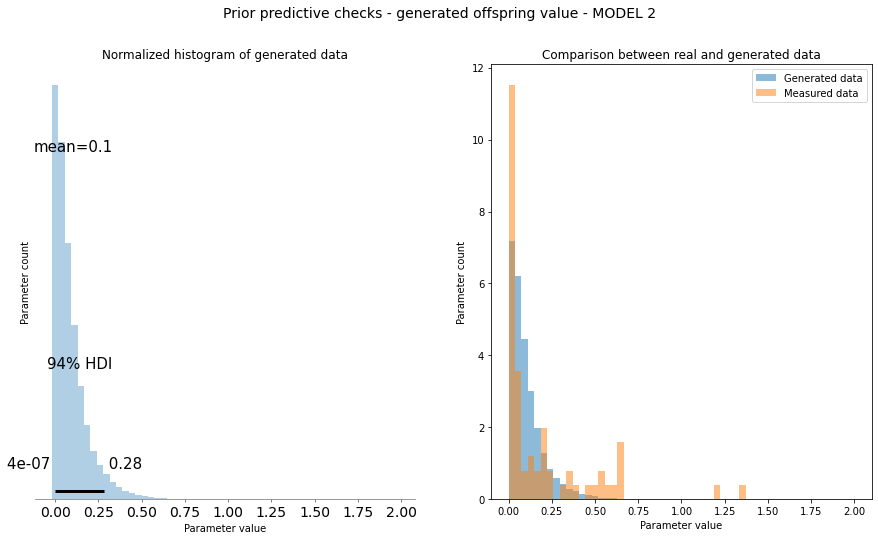

In [41]:
fig2, ax2= plt.subplots(1,2, figsize=(15,8))
fig2.suptitle("Prior predictive checks - generated offspring value - MODEL 2", fontsize=14)

# get measurements
model25_ppc_measurements = sim_ppc25.stan_variable('output').flatten()  # flatten makes it row/column vector (one of these)

# set bins
bins = np.linspace(0,2, 55)
# bins1 = np.linspace(0, 25, 100)

az.plot_posterior(model25_ppc_measurements[model25_ppc_measurements<100], kind='hist', ax=ax2[0], bins=bins, group='prior', backend="matplotlib", log=False)
ax2[0].set_xlabel("Parameter value")
ax2[0].set_ylabel("Parameter count")
ax2[0].set_title("Normalized histogram of generated data")

# # plot measurements
ax2[1].hist(model25_ppc_measurements[model25_ppc_measurements<100], density=True, bins=bins,  alpha=0.5, label="Generated data")

# compare with real data, density set to True because each data point sampled 999 times
ax2[1].hist(df_copy['value_numeric'], density=True, bins=bins, alpha=0.5, label="Measured data", log=False)
ax2[1].legend()
ax2[1].set_xlabel("Parameter value")
ax2[1].set_ylabel("Parameter count")
ax2[1].set_title("Comparison between real and generated data")
plt.show()

## Posterior


In [30]:
model2_posterior2 = CmdStanModel(stan_file='models/v2_model2_post.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [31]:
data = { 'N': len(df_copy),
        'output': df_copy.value_numeric,
        'dad_val': df_copy.dad_value_numeric,
        'dad_ns': df_copy.dad_num_of_starts,
        'dad_fp': df_copy.dad_first_place,
        'dad_sp': df_copy.dad_second_place,
        'dad_tp': df_copy.dad_third_place,
        'mum_val': df_copy.mum_value_numeric,
        'mum_fp': df_copy.mum_first_place,
        'mum_sp': df_copy.mum_second_place,
        'mum_tp': df_copy.mum_third_place,
        'mum_ns': df_copy.mum_num_of_starts
         }

sim_post25 = model2_posterior2.sample(data=data, 
                        iter_sampling=1000,
                        iter_warmup=0, 
                        chains=1, 
                        fixed_param=True,
                        # show_console=True,
                        seed=20230613)

sim_post25_df = sim_post25.draws_pd()
sim_post25_df.head()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,dad_ns_coef,dad_fp_coef,dad_sp_coef,dad_tp_coef,dad_val_coef,mum_ns_coef,mum_fp_coef,mum_sp_coef,...,log_likelyhood[59],log_likelyhood[60],log_likelyhood[61],log_likelyhood[62],log_likelyhood[63],log_likelyhood[64],log_likelyhood[65],log_likelyhood[66],log_likelyhood[67],log_likelyhood[68]
0,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,-1911.86,-3386.55,-4668.25,-1913.59,-2312.73,-8.72223,-22.531,-175.389,-58.1305,3.53171
1,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,-1911.86,-3386.55,-4668.25,-1913.59,-2312.73,-8.72223,-22.531,-175.389,-58.1305,3.53171
2,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,-1911.86,-3386.55,-4668.25,-1913.59,-2312.73,-8.72223,-22.531,-175.389,-58.1305,3.53171
3,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,-1911.86,-3386.55,-4668.25,-1913.59,-2312.73,-8.72223,-22.531,-175.389,-58.1305,3.53171
4,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,-1911.86,-3386.55,-4668.25,-1913.59,-2312.73,-8.72223,-22.531,-175.389,-58.1305,3.53171


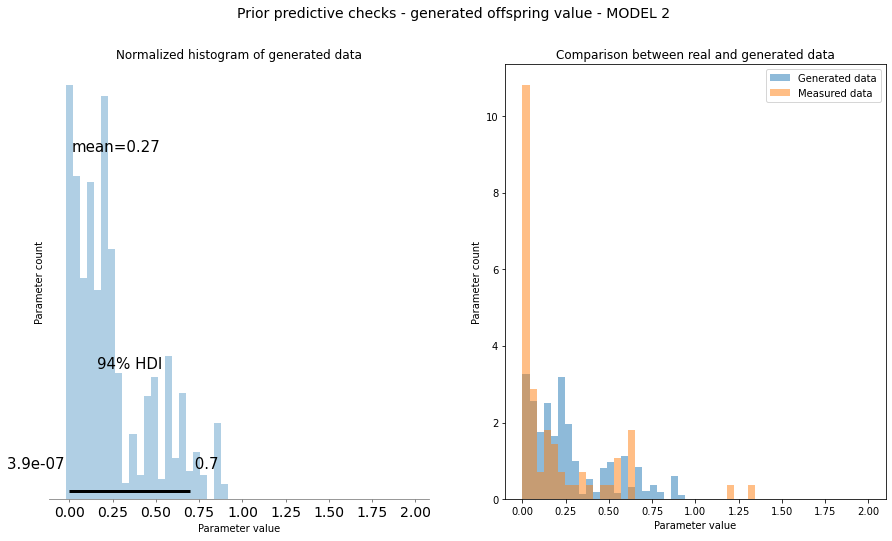

In [43]:
fig2, ax2= plt.subplots(1,2, figsize=(15,8))
fig2.suptitle("Prior predictive checks - generated offspring value - MODEL 2", fontsize=14)

# get measurements
model25_post_measurements = sim_post25.stan_variable('output_pred').flatten()  # flatten makes it row/column vector (one of these)

# set bins
bins = np.linspace(0, 2, 50)
# bins2 = np.linspace(0, 10, 100)
az.plot_posterior(model25_post_measurements[model25_post_measurements<10], kind='hist', ax=ax2[0], bins=bins, group='prior', backend="matplotlib", log=False)
ax2[0].set_xlabel("Parameter value")
ax2[0].set_ylabel("Parameter count")
ax2[0].set_title("Normalized histogram of generated data")

# # plot measurements
ax2[1].hist(model25_post_measurements[model25_post_measurements<10], density=True, bins=bins,  alpha=0.5, label="Generated data")

# compare with real data, density set to True because each data point sampled 999 times
ax2[1].hist(df_copy['value_numeric'], density=True, bins=bins, alpha=0.5, label="Measured data", log=False)
ax2[1].legend()
ax2[1].set_xlabel("Parameter value")
ax2[1].set_ylabel("Parameter count")
ax2[1].set_title("Comparison between real and generated data")
plt.show()

# Model Comparision   

In [44]:
fit1_id = az.from_cmdstanpy(posterior=sim_post1,
                            log_likelihood='log_likelyhood',
                            posterior_predictive='output_pred',
                            observed_data={'kid_value': df_copy["value_numeric"]})

fit2_id = az.from_cmdstanpy(posterior=sim_post2,
                            log_likelihood='log_likelyhood',
                            posterior_predictive='output_pred',
                            observed_data={'kid_value': df_copy["value_numeric"]})

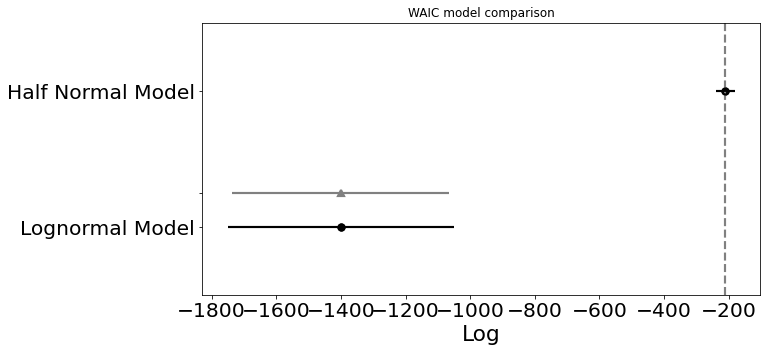

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Half Normal Model,0,-210.794663,1.013594e-28,0.000000,0.686824,29.853334,0.000000,False,log
Lognormal Model,1,-1400.346362,6.981707e-27,1189.551699,0.313176,350.347212,335.446268,False,log


In [51]:
waic = az.compare({'Lognormal Model': fit1_id, 'Half Normal Model': fit2_id}, ic="waic")
az.plot_compare(waic, figsize=(10, 5))
plt.title("WAIC model comparison")
plt.show()
waic

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


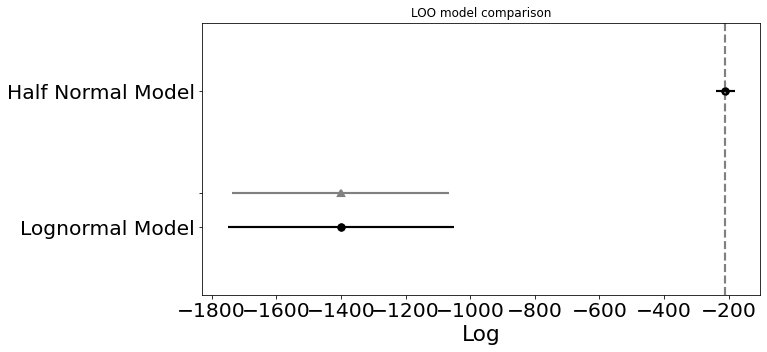

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Half Normal Model,0,-210.794663,0.0,0.000000,0.686824,29.853334,0.000000,True,log
Lognormal Model,1,-1400.346362,0.0,1189.551699,0.313176,350.347212,335.446268,True,log


In [50]:
waic = az.compare({'Lognormal Model': fit1_id, 'Half Normal Model': fit2_id}, ic="loo")
az.plot_compare(waic, figsize=(10, 5))
plt.title("LOO model comparison")
plt.show()
waic